### Importing the neccessary dependencies


In [1]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization

# Import PyTorch libraries for building neural networks
import torch  # Core library for tensor computations
import torch.nn as nn  # Module for neural network layers and functions

# Load the dataset into a Pandas DataFrame
data = pd.read_csv('/content/GBP_USD Historical Data.csv')  # Read the CSV file containing GBP to USD historical exchange rate data

# Display the loaded dataset
data  # This will output the contents of the DataFrame

,Date,Price,Open,High,Low,Vol.,Change %
0,04/30/2024,1.2495,1.2559,1.2562,1.2493,NaN,-0.52%
1,04/29/2024,1.2560,1.2510,1.2570,1.2507,NaN,0.57%
2,04/26/2024,1.2489,1.2520,1.2542,1.2448,NaN,-0.19%
3,04/25/2024,1.2513,1.2464,1.2527,1.2449,NaN,0.42%
4,04/24/2024,1.2461,1.2450,1.2471,1.2421,NaN,0.10%
...,...,...,...,...,...,...,...
3648,05/06/2010,1.4764,1.5105,1.5149,1.4712,NaN,-2.22%
3649,05/05/2010,1.5099,1.5129,1.5174,1.5067,NaN,-0.25%
3650,05/04/2010,1.5137,1.5238,1.5269,1.5090,NaN,-0.71%
3651,05/03/2010,1.5246,1.5316,1.5320,1.5212,NaN,-0.16%


In [2]:
# Rename the 'Price' column to 'Close' for better clarity and consistency with financial terminology
data.rename(columns={'Price': 'Close'}, inplace=True)  # Update the DataFrame in place to reflect the new column name

In [3]:
data.columns # output the fields

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [4]:
data['Vol.'].values

array([nan, nan, nan, ..., nan, nan, nan])

In [5]:
# checking for missing values
data.isnull().sum()

,0
Date,0
Close,0
Open,0
High,0
Low,0
Vol.,3653
Change %,0


In [6]:
data['Vol.'].dropna() # dropping the missing values

,Vol.


In [7]:
data.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,04/30/2024,1.2495,1.2559,1.2562,1.2493,NaN,-0.52%
1,04/29/2024,1.2560,1.2510,1.2570,1.2507,NaN,0.57%
2,04/26/2024,1.2489,1.2520,1.2542,1.2448,NaN,-0.19%
3,04/25/2024,1.2513,1.2464,1.2527,1.2449,NaN,0.42%
4,04/24/2024,1.2461,1.2450,1.2471,1.2421,NaN,0.10%


In [8]:
## getting the date and close entries

data = data[['Date', 'Close']]
data

,Date,Close
0,04/30/2024,1.2495
1,04/29/2024,1.2560
2,04/26/2024,1.2489
3,04/25/2024,1.2513
4,04/24/2024,1.2461
...,...,...
3648,05/06/2010,1.4764
3649,05/05/2010,1.5099
3650,05/04/2010,1.5137
3651,05/03/2010,1.5246


In [9]:
# checking the processor in use
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-10-1db96b14793e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


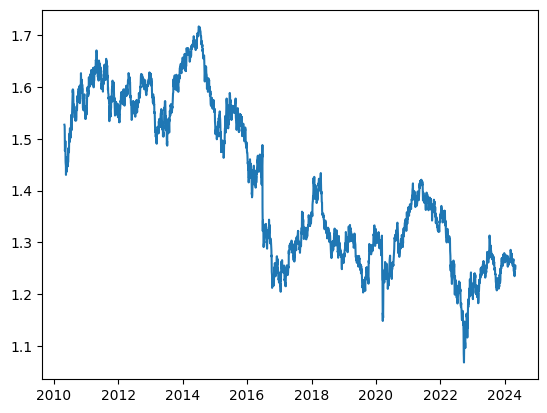

In [10]:
# converting the date column from strings to datatime
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [11]:
# Preparing the dataset for building an LSTM RNN model
from copy import deepcopy as dc  # Importing deepcopy to avoid modifying the original DataFrame

def prepare_dataframe_for_lstm(df, n_steps):
    # Create a deep copy of the DataFrame to avoid altering the original data
    df = dc(df)

    # Set 'Date' column as the index for time series analysis
    df.set_index('Date', inplace=True)

    # Create lagged features for 'Close' prices based on the specified number of steps (lookback period)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)  # Create a new column for each lagged value

    # Remove rows with NaN values that result from the shifting operation
    df.dropna(inplace=True)

    return df  # Return the modified DataFrame with lagged features

# Define the number of previous time steps to use as input for the LSTM
lookback = 7
# Prepare the DataFrame by generating lagged features based on the specified lookback
shifted_df = prepare_dataframe_for_lstm(data, lookback)
# Display the transformed DataFrame
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2024-04-19,1.2371,1.2349,1.2448,1.2461,1.2513,1.2489,1.2560,1.2495
2024-04-18,1.2435,1.2371,1.2349,1.2448,1.2461,1.2513,1.2489,1.2560
2024-04-17,1.2446,1.2435,1.2371,1.2349,1.2448,1.2461,1.2513,1.2489
2024-04-16,1.2424,1.2446,1.2435,1.2371,1.2349,1.2448,1.2461,1.2513
2024-04-15,1.2444,1.2424,1.2446,1.2435,1.2371,1.2349,1.2448,1.2461
...,...,...,...,...,...,...,...,...
2010-05-06,1.4764,1.4802,1.4848,1.4956,1.4825,1.4607,1.4539,1.4478
2010-05-05,1.5099,1.4764,1.4802,1.4848,1.4956,1.4825,1.4607,1.4539
2010-05-04,1.5137,1.5099,1.4764,1.4802,1.4848,1.4956,1.4825,1.4607


In [12]:
# converting to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[1.2371, 1.2349, 1.2448, ..., 1.2489, 1.256 , 1.2495],
       [1.2435, 1.2371, 1.2349, ..., 1.2513, 1.2489, 1.256 ],
       [1.2446, 1.2435, 1.2371, ..., 1.2461, 1.2513, 1.2489],
       ...,
       [1.5137, 1.5099, 1.4764, ..., 1.4956, 1.4825, 1.4607],
       [1.5246, 1.5137, 1.5099, ..., 1.4848, 1.4956, 1.4825],
       [1.5271, 1.5246, 1.5137, ..., 1.4802, 1.4848, 1.4956]])

In [13]:
# checking the shape
shifted_df_as_np.shape

(3646, 8)

In [14]:
# scaling transformation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.47948164, -0.48626967, -0.45572354, ..., -0.44307313,
        -0.42116631, -0.44122185],
       [-0.45973465, -0.47948164, -0.48626967, ..., -0.435668  ,
        -0.44307313, -0.42116631],
       [-0.45634064, -0.45973465, -0.47948164, ..., -0.45171243,
        -0.435668  , -0.44307313],
       ...,
       [ 0.37395865,  0.36223388,  0.25887072, ...,  0.31811169,
         0.27769207,  0.21042888],
       [ 0.40759025,  0.37395865,  0.36223388, ...,  0.28478865,
         0.31811169,  0.27769207],
       [ 0.41530392,  0.40759025,  0.37395865, ...,  0.2705955 ,
         0.28478865,  0.31811169]])

In [15]:
# feature selection
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3646, 7), (3646,))

In [16]:
# Flip the data along the X-axis (horizontal flip) to reverse the order of the features
X = dc(np.flip(X, axis=1))  # Create a deep copy of the flipped array to preserve the original data
# Display the flipped data
X

array([[-0.44122185, -0.42116631, -0.44307313, ..., -0.45171243,
        -0.45572354, -0.48626967],
       [-0.42116631, -0.44307313, -0.435668  , ..., -0.45572354,
        -0.48626967, -0.47948164],
       [-0.44307313, -0.435668  , -0.45171243, ..., -0.48626967,
        -0.47948164, -0.45973465],
       ...,
       [ 0.21042888,  0.27769207,  0.31811169, ...,  0.2705955 ,
         0.25887072,  0.36223388],
       [ 0.27769207,  0.31811169,  0.28478865, ...,  0.25887072,
         0.36223388,  0.37395865],
       [ 0.31811169,  0.28478865,  0.2705955 , ...,  0.36223388,
         0.37395865,  0.40759025]])

In [17]:
# Calculate the index to split the dataset into training and testing sets
# Using 95% of the data for training and the remaining 5% for testing
split_index = int(len(X) * 0.95)

# Display the calculated split index
split_index

3463

In [18]:
## Splitting the data into training and testing sets

# Create the training set using the first 95% of the data
X_train = X[:split_index]  # Features for training
y_train = y[:split_index]  # Target values for training

# Create the testing set using the remaining 5% of the data
X_test = X[split_index:]   # Features for testing
y_test = y[split_index:]   # Target values for testing

# Display the shapes of the training and testing sets for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3463, 7), (183, 7), (3463,), (183,))

In [19]:
# Reshape the training and testing feature sets to match the input shape required by the LSTM model
# The shape will be (samples, time steps, features), where 'samples' is inferred automatically (-1),
# 'lookback' is the number of time steps, and '1' represents the single feature (Close price)

X_train = X_train.reshape((-1, lookback, 1))  # Reshape training features
X_test = X_test.reshape((-1, lookback, 1))    # Reshape testing features

# Reshape the target values to ensure they have the shape (samples, 1)
y_train = y_train.reshape((-1, 1))  # Reshape training targets
y_test = y_test.reshape((-1, 1))    # Reshape testing targets

# Display the shapes of the reshaped datasets for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3463, 7, 1), (183, 7, 1), (3463, 1), (183, 1))

In [20]:
# Convert the training and testing datasets from NumPy arrays to PyTorch tensors
# This is necessary for compatibility with PyTorch models

X_train = torch.tensor(X_train).float()  # Convert training features to a float tensor
y_train = torch.tensor(y_train).float()  # Convert training targets to a float tensor
X_test = torch.tensor(X_test).float()    # Convert testing features to a float tensor
y_test = torch.tensor(y_test).float()    # Convert testing targets to a float tensor

# Display the shapes of the tensors to verify the conversion
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3463, 7, 1]),
 torch.Size([183, 7, 1]),
 torch.Size([3463, 1]),
 torch.Size([183, 1]))

In [21]:
from torch.utils.data import Dataset  # Importing the Dataset class from PyTorch for custom dataset creation

# Define a custom dataset class for time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Initialize the dataset with features (X) and targets (y)
        self.X = X  # Store the feature tensor
        self.y = y  # Store the target tensor

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.X)  # Number of samples is based on the length of X

    def __getitem__(self, i):
        # Retrieve a sample from the dataset
        return self.X[i], self.y[i]  # Return the feature and target at index i

# Create instances of the TimeSeriesDataset for training and testing data
train_dataset = TimeSeriesDataset(X_train, y_train)  # Training dataset
test_dataset = TimeSeriesDataset(X_test, y_test)      # Testing dataset

In [22]:
train_dataset

In [23]:
from torch.utils.data import DataLoader  # Importing the DataLoader class for loading data in batches

# Define the batch size for training and testing
batch_size = 16  # Number of samples per batch

# Create a DataLoader for the training dataset
# It shuffles the data at every epoch for better generalization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the testing dataset
# No shuffling is performed for the testing data to maintain the order of samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Iterate over the training DataLoader to retrieve batches of data
for _, batch in enumerate(train_loader):
    # Unpack the batch into features (x_batch) and targets (y_batch)
    # Move the tensors to the specified device (CPU or GPU)
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    # Print the shapes of the feature and target batches for verification
    print(x_batch.shape, y_batch.shape)

    # Break after the first batch to avoid printing shapes for all batches
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [25]:
import torch.nn as nn  # Importing the neural network module from PyTorch

# Define an LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()  # Initialize the parent class
        self.hidden_size = hidden_size  # Set the hidden size
        self.num_stacked_layers = num_stacked_layers  # Set the number of stacked LSTM layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x):
        # Define the forward pass
        batch_size = x.size(0)  # Get the batch size from input
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Pass the input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))  # Get the output and hidden states

        # Pass the output from the last time step through the fully connected layer
        out = self.fc(out[:, -1, :])  # Only take the last time step's output
        return out  # Return the final output

# Create an instance of the LSTM model with specified parameters
model = LSTM(1, 4, 1)  # Input size of 1, hidden size of 4, and 1 stacked layer
model.to(device)  # Move the model to the specified device (CPU or GPU)

# Display the model architecture
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
def train_one_epoch():
    # Set the model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')  # Print the current epoch number
    running_loss = 0.0  # Initialize cumulative loss for the epoch

    # Iterate over the training DataLoader
    for batch_index, batch in enumerate(train_loader):
        # Move the batch data to the specified device (CPU or GPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: Get model predictions
        output = model(x_batch)

        # Calculate the loss between predictions and true values
        loss = loss_function(output, y_batch)
        running_loss += loss.item()  # Accumulate the loss

        # Backward pass: Compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagate to compute current gradients
        optimizer.step()       # Update model parameters

        # Print the average loss every 100 batches
        if batch_index % 100 == 99:  # Every 100 batches
            avg_loss_across_batches = running_loss / 100  # Calculate average loss
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0  # Reset running loss for the next 100 batches

    print()  # Print a newline for better readability at the end of the epoch

In [27]:
def validate_one_epoch():
    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    model.train(False)
    running_loss = 0.0  # Initialize cumulative loss for the validation epoch

    # Iterate over the testing DataLoader
    for batch_index, batch in enumerate(test_loader):
        # Move the batch data to the specified device (CPU or GPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disable gradient calculation for validation (saves memory and computation)
        with torch.no_grad():
            # Forward pass: Get model predictions
            output = model(x_batch)
            # Calculate the loss between predictions and true values
            loss = loss_function(output, y_batch)
            running_loss += loss.item()  # Accumulate the loss

    # Calculate the average loss across all batches in the validation set
    avg_loss_across_batches = running_loss / len(test_loader)

    # Print the average validation loss for this epoch
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')  # Separator for readability
    print()  # Print a newline for better readability at the end of validation

In [28]:
# Set the learning rate for the optimizer
learning_rate = 0.001  # A common choice for Adam optimizer

# Define the number of epochs for training
num_epochs = 10  # Total number of epochs to train the model

# Define the loss function to be used
loss_function = nn.MSELoss()  # Mean Squared Error Loss for regression tasks

# Initialize the Adam optimizer with the model parameters and specified learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop for the specified number of epochs
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_one_epoch()
    # Validate the model after training for the epoch
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.390
Batch 200, Loss: 0.195

Val Loss: 0.040
***************************************************

Epoch: 2
Batch 100, Loss: 0.016
Batch 200, Loss: 0.004

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002

Val Loss: 0.003
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.002
***************************************************



In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Importing metrics for evaluation

# Calculate the Mean Absolute Error (MAE) and Mean Squared Error (MSE)
# Move the test features to the specified device, get predictions, and detach from the computation graph
y_pred = model(X_test.to(device)).detach().cpu().numpy()  # Obtain predictions as a NumPy array

# Compute the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)  # Compare true values to predictions

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)  # Compare true values to predictions

# Print the evaluation metrics
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}')  # Display MAE and MSE with 4 decimal precision

MAE: 0.0343, MSE: 0.0018


In [30]:
from sklearn.metrics import r2_score  # Importing the R² score metric for evaluation

# Calculate the R² score, which indicates the proportion of variance explained by the model
r2 = r2_score(y_test, y_pred=model(X_test.to(device)).detach().cpu().numpy())  # Compare true values to predictions

# Print the R² score
print(f'R2 Score: {r2:.4f}')  # Display the R² score with 4 decimal precision

R2 Score: 0.9176


In [31]:

y_test = y_test.detach().cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Get predictions from the model
y_pred = model(X_test.to(device)).detach().cpu().numpy()

# Ensure both y_test and y_pred are 1D arrays
if y_test.ndim > 1:
    y_test = y_test.flatten()
if y_pred.ndim > 1:
    y_pred = y_pred.flatten()

# Calculate percentage error
percentage_error = np.abs((y_test - y_pred) / y_test) * 100

# Print percentage error for each prediction
for i, error in enumerate(percentage_error):
    print(f'Percentage Error for sample {i}: {error:.2f}%')

Percentage Error for sample 0: 15.63%
Percentage Error for sample 1: 14.73%
Percentage Error for sample 2: 11.70%
Percentage Error for sample 3: 14.93%
Percentage Error for sample 4: 7.69%
Percentage Error for sample 5: 0.82%
Percentage Error for sample 6: 7.34%
Percentage Error for sample 7: 1.81%
Percentage Error for sample 8: 11.18%
Percentage Error for sample 9: 3.64%
Percentage Error for sample 10: 11.50%
Percentage Error for sample 11: 6.55%
Percentage Error for sample 12: 3.69%
Percentage Error for sample 13: 4.26%
Percentage Error for sample 14: 6.72%
Percentage Error for sample 15: 0.12%
Percentage Error for sample 16: 2.05%
Percentage Error for sample 17: 2.21%
Percentage Error for sample 18: 6.42%
Percentage Error for sample 19: 1.96%
Percentage Error for sample 20: 11.08%
Percentage Error for sample 21: 10.67%
Percentage Error for sample 22: 4.86%
Percentage Error for sample 23: 0.01%
Percentage Error for sample 24: 0.74%
Percentage Error for sample 25: 2.62%
Percentage Err

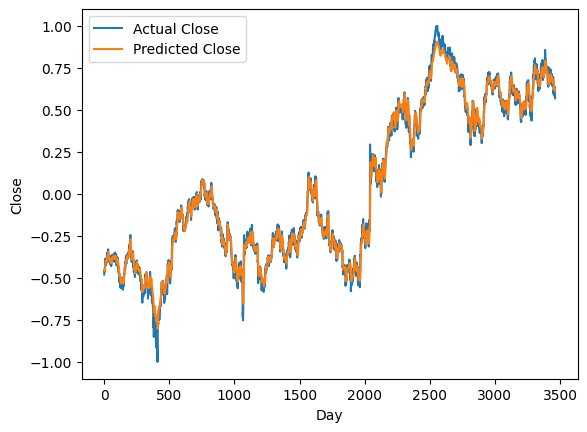

In [32]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [33]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([1.24602586, 1.24392337, 1.24421285, ..., 1.59565108, 1.59392812,
       1.59144809])

In [34]:
# Create an array to hold the true values and prepare for inverse scaling
dummies = np.zeros((X_train.shape[0], lookback + 1))  # Initialize an array with zeros

# Fill the first column with the flattened true values from y_train
dummies[:, 0] = y_train.flatten()  # Flatten y_train to a 1D array and store in the first column

# Inverse transform the scaled data to obtain the original scale values
dummies = scaler.inverse_transform(dummies)  # Apply inverse scaling to recover original values

# Create a deep copy of the first column (original true values)
new_y_train = dc(dummies[:, 0])  # Store the recovered true values in new_y_train

# Display the new_y_train values
new_y_train

array([1.2371    , 1.2435    , 1.2446    , ..., 1.58629999, 1.5837    ,
       1.57700001])

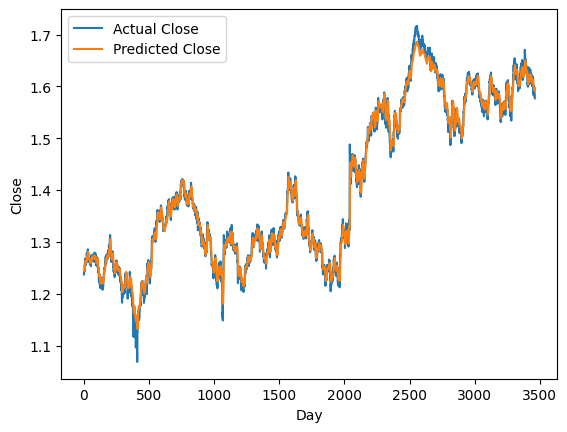

In [35]:
# Plot the actual and predicted closing prices for comparison
plt.plot(new_y_train, label='Actual Close')  # Plot the actual closing prices from the training set
plt.plot(train_predictions, label='Predicted Close')  # Plot the predicted closing prices

# Label the x-axis and y-axis
plt.xlabel('Day')  # X-axis represents the days
plt.ylabel('Close')  # Y-axis represents the closing prices

# Add a legend to differentiate between actual and predicted values
plt.legend()

# Display the plot
plt.show()  # Render the plot to the screen

In [36]:
# Generate predictions for the test set using the trained model
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()  # Get predictions and flatten to 1D array

# Create an array to hold the predictions and prepare for inverse scaling
dummies = np.zeros((X_test.shape[0], lookback + 1))  # Initialize an array with zeros

# Fill the first column with the flattened test predictions
dummies[:, 0] = test_predictions  # Store the test predictions in the first column

# Inverse transform the scaled data to obtain the original scale values
dummies = scaler.inverse_transform(dummies)  # Apply inverse scaling to recover original values

# Create a deep copy of the first column (original test predictions)
test_predictions = dc(dummies[:, 0])  # Store the recovered test predictions

# Display the test_predictions values
test_predictions

array([1.58791408, 1.5814679 , 1.57491026, 1.56960074, 1.56340581,
       1.55995522, 1.55962283, 1.55717031, 1.55881786, 1.55562871,
       1.55506498, 1.55179816, 1.55000137, 1.54920819, 1.54851992,
       1.5466915 , 1.54784828, 1.54993428, 1.55252577, 1.55705549,
       1.55806859, 1.56508241, 1.57249661, 1.57702363, 1.57901391,
       1.58101316, 1.58119011, 1.58000399, 1.57994183, 1.5756052 ,
       1.57265965, 1.56861089, 1.56592718, 1.56460275, 1.56814746,
       1.57156657, 1.57474799, 1.58144626, 1.58761427, 1.59357827,
       1.59457855, 1.59426769, 1.59774691, 1.60227235, 1.60504365,
       1.60724435, 1.60581772, 1.60796595, 1.61065152, 1.61417301,
       1.61346528, 1.61133981, 1.60932241, 1.6079858 , 1.60437893,
       1.59738644, 1.59304792, 1.58777244, 1.58255306, 1.57910977,
       1.58013145, 1.57845679, 1.58191229, 1.58700247, 1.59180068,
       1.59296632, 1.59125885, 1.59095351, 1.59302651, 1.59226798,
       1.59169911, 1.59115403, 1.58954825, 1.58817954, 1.58436

In [37]:
# Create an array to hold the true values for the test set and prepare for inverse scaling
dummies = np.zeros((X_test.shape[0], lookback + 1))  # Initialize an array with zeros

# Fill the first column with the flattened true values from y_test
dummies[:, 0] = y_test.flatten()  # Flatten y_test to a 1D array and store in the first column

# Inverse transform the scaled data to recover the original scale values
dummies = scaler.inverse_transform(dummies)  # Apply inverse scaling to recover original values

# Create a deep copy of the first column (original true test values)
new_y_test = dc(dummies[:, 0])  # Store the recovered true values in new_y_test

# Display the new_y_test values
new_y_test

array([1.56150001, 1.55720001, 1.5558    , 1.5466    , 1.5512    ,
       1.55859999, 1.5482    , 1.56019999, 1.5421    , 1.5499    ,
       1.5383    , 1.542     , 1.5444    , 1.5428    , 1.5387    ,
       1.5465    , 1.5511    , 1.5535    , 1.56350001, 1.5539    ,
       1.5787    , 1.5857    , 1.5817    , 1.57700001, 1.58040001,
       1.5762    , 1.5711    , 1.57790001, 1.56060001, 1.56289999,
       1.5553    , 1.55749999, 1.5594    , 1.5762    , 1.57790001,
       1.578     , 1.59590001, 1.59860001, 1.6046    , 1.58960001,
       1.58899999, 1.60629999, 1.6136    , 1.6116    , 1.61239999,
       1.5987    , 1.614     , 1.6179    , 1.62650001, 1.6098    ,
       1.6044    , 1.60380001, 1.60400001, 1.5943    , 1.5774    ,
       1.58420001, 1.5733    , 1.5686    , 1.5708    , 1.58469999,
       1.57160001, 1.59      , 1.59930001, 1.601     , 1.5898    ,
       1.5808    , 1.588     , 1.59660001, 1.58780001, 1.58940001,
       1.5886    , 1.5823    , 1.5817    , 1.5713    , 1.5789 

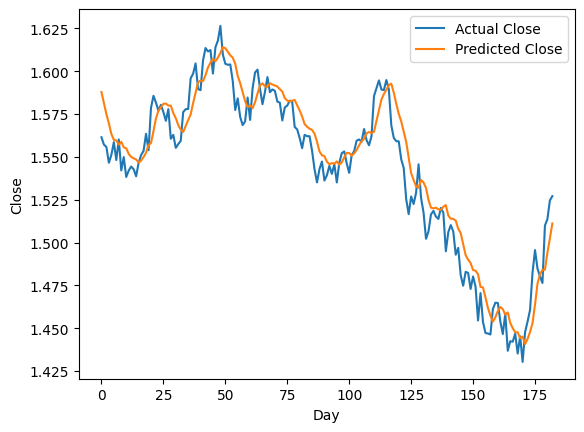

In [38]:
# Plot the actual and predicted closing prices for the test set
plt.plot(new_y_test, label='Actual Close')  # Plot the actual closing prices from the test set
plt.plot(test_predictions, label='Predicted Close')  # Plot the predicted closing prices

# Label the x-axis and y-axis
plt.xlabel('Day')  # X-axis represents the days in the test set
plt.ylabel('Close')  # Y-axis represents the closing prices

# Add a legend to differentiate between actual and predicted values
plt.legend()

# Display the plot
plt.show()  # Render the plot to the screen
